# CS Department Comparison

## Data Collection

### Class Sizes Data

As a UMD student, we have [Testudo](https://app.testudo.umd.edu/soc/) which lists our schedule of classes with their associated class sizes. I can scrape this page to get the CS class sizes at UMD. I assumed other public universities would have similar systems but they would all be different and would take time for me to learn. To solve this problem, I made several Reddit posts asking for similar systems to Testudo at other universities on their associated subreddits. Students on Reddit were very helpful and gave me tips on how to get what I was looking for, and this saved me a lot of time.

I had time to scrape data for 5 universities, and I plan to expand this list eventually:

- University of Maryland
- Georgia Tech
- University of Washington
- University of Michigan
- University of California Berkeley

#### University of Maryland

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/umd/umd_combined.csv

UMD students created a website called PlanetTerp which has course reviews, instructor reviews, and grade distribution data. I used their public API to get CS course enrollment information for the fall 2021 semester. Their api documentation can be found here: https://api.planetterp.com/#planetterp-api

The first step was getting a list of CS courses offered by UMD, and I did this by calling their "courses" endpoint and searching for CS classes which are prefixed with "CMSC" at UMD. I changed the default class return limit to 300 because UMD has offered over 100 different CS courses over the years. I also extract the professors which have taught each of these courses over the years because this will help me determine section sizes for the fall 2021 semester.

I then use PlanetTerp's "grades" endpoint to get the course grades for the fall 2021 semester of a certain course with a certain professor. If that professor wasn't teaching that semester but has taught in the past, the api would return 0 for them. This endpoint returns all the sections of that professor, which for some courses is the sizes of a bunch of their discussions. Some cleaning of the data needs to be done to get their lecture size.

I will not be running and showing the output of the scraper below since it takes a while to complete. The "umd.csv" generated will be shown in the following code cell.

In [1]:
%%script false --no-raise-error

import requests
from time import sleep
import pandas as pd


# get list of cs courses
params = {"department": "CMSC", "limit": 300}
cs_courses_data = requests.get("https://api.planetterp.com/v1/courses", params=params).json()

cs_course_nums = []

for course in cs_courses_data:
    cs_course_nums.append(course['department'] + str(course['course_number']))

# list of professors for each course so can get grades for each professor of the
# course during a specific semester to see how big lectures arec
course_professors = []

for course in cs_courses_data:
    course_professors.append(course["professors"])

class_names = []
class_sizes = []
class_profs = []

# get grades for each course in dictionary
semester = "202108" # fall 2021
for i, course in enumerate(cs_course_nums):
    for prof in course_professors[i]:
        params = {"course": course, "semester": semester, "professor": prof}

        # for each course returns a list of sections with corresponding grade data
        sections = requests.get("https://api.planetterp.com/v1/grades", params=params).json()

        print("{} {}".format(course, prof))
        for section in sections:
            # didn't get back a dictionary on the api call for some reason so skip
            # the reason seems to be inconsistent naming of professors so some
            # names of the same professor return nothing
            if not type(section) is dict:
                print("skipping")
                continue
            total_students_section = 0
            # convert section dictionary into list so only preserve items that have grade counts
            section_grades = list(section.items())[4:]
            for grade in section_grades:
                # add number of students who got this grade in this section to total students in section
                total_students_section += grade[1]
            
            # append section info to lists
            class_names.append(course)
            class_profs.append(prof)
            class_sizes.append(total_students_section)

        sleep(0.5)

# create dataframe from course counts
data_dict = {"course_name": class_names, "professor": class_profs, "count": class_sizes}

courses_df = pd.DataFrame.from_dict(data_dict)

courses_df.to_csv("umd.csv")


In [2]:
import pandas as pd
umd_data = pd.read_csv("class_sizes_data/umd.csv")
umd_data

,Unnamed: 0,course_name,professor,count
0,0,CMSC100,Jessica Long,33
1,1,CMSC100,Corie Brown,17
2,2,CMSC100,Veronica Sanchez,19
3,3,CMSC106,Jandelyn Plane,51
4,4,CMSC122,Pedram Sadeghian,83
...,...,...,...,...
183,183,CMSC829A,Erin Molloy,21
184,184,CMSC838G,Leonidas Lampropoulos,11
185,185,CMSC848B,Christopher Metzler,21
186,186,CMSC858G,Michael Gullans,28


##### Cleaning UMD Data

The list of discussion sections for each professor needs to be combined by professor and course to get the lecture size of that course for that professor.

In [3]:
classes_df = pd.read_csv("class_sizes_data/umd.csv")

# if row course_name and professor are the same, combine rows into one row

grouped = classes_df.groupby(["course_name", "professor"])

umd = grouped.agg({"count": "sum"})

umd

count
course_name professor                   
CMSC100     Corie Brown               17
            Jessica Long              33
            Veronica Sanchez          19
CMSC106     Jandelyn Plane            51
CMSC122     Jennifer Manly            61
...                                  ...
CMSC829A    Erin Molloy               21
CMSC838G    Leonidas Lampropoulos     11
CMSC848B    Christopher Metzler       21
CMSC858G    Michael Gullans           28
CMSC858O    Xiaodi Wu                 12

[82 rows x 1 columns]

#### Georgia Tech

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/gatech/gatech.csv

Georgia Tech has a public class registry called Oscar located at:  https://oscar.gatech.edu/. The user can search for all CS courses in a specific term and Oscar will generate a static HTML page response that can be scraped for data. However, it takes a long time for this query to execute so I saved this HTML page locally to then be loaded by my program later. I used the Python package [Uncurl](https://github.com/spulec/uncurl) to generate the appropriate POST request. My code to get the HTML is below:

In [4]:
%%script false --no-raise-error
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from time import sleep
import json

res = requests.post("https://oscar.gatech.edu/bprod/bwckschd.p_get_crse_unsec",
    data='term_in=202108&sel_subj=dummy&sel_day=dummy&sel_schd=dummy&sel_insm=dummy&sel_camp=dummy&sel_levl=dummy&sel_sess=dummy&sel_instr=dummy&sel_ptrm=dummy&sel_attr=dummy&sel_subj=CS&sel_crse=&sel_title=&sel_schd=%25&sel_from_cred=&sel_to_cred=&sel_camp=A&sel_ptrm=%25&sel_instr=%25&sel_attr=%25&begin_hh=0&begin_mi=0&begin_ap=a&end_hh=0&end_mi=0&end_ap=a',
    headers={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "en-US,en;q=0.5",
        "Connection": "keep-alive",
        "Content-Type": "application/x-www-form-urlencoded",
        "DNT": "1",
        "Origin": "https://oscar.gatech.edu",
        "Referer": "https://oscar.gatech.edu/bprod/bwckgens.p_proc_term_date",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "same-origin",
        "Sec-Fetch-User": "?1",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:99.0) Gecko/20100101 Firefox/99.0"
    },
    cookies={
        "BIGipServer~BANNER~oscar.coda_443": "572230154.64288.0000"
    },
    auth=(),
)

# save response in html so don't have to do 10 sec query every time
with open("gatech.html", "w") as f:
    f.write(res.text)

I have the HTML page which lists all of the CS classes for the fall 2021 term, great! But while the page lists the classes, you have to click on each class to get to how many seats are in that class. This means I'll have to make a program which gets all the links, goes to each link, and extracts the appropriate class data from each class page. The code to do that is below but won't be run because it takes a while.

In [5]:
%%script false --no-raise-error

# link to class with seats is of form bprod/bwckschd.p_disp_detail_sched?term_in=202108&crn_in=93519
# get all links on page and filter for links like this

f = open("gatech.html", "r")

soup = BeautifulSoup(f, 'html.parser')

links = soup.find_all('a')

class_links = []
class_titles = []

for link in links:
    if link.get('href') != None and "bprod/bwckschd.p_disp_detail_sched?term_in=202108" in link.get('href'):
        class_links.append(link.get('href'))
        class_titles.append(link.get_text())

f.close()

class_data = {"title": class_titles, "link": class_links}

classes_df = pd.DataFrame.from_dict(class_data)

# print(classes_df)

# extracting class name from title which has other junk

classes_df["class_name"] = ""

for index, row in classes_df.iterrows():
    class_name = re.findall("CS \d{4}", row['title'])[0]
    classes_df.at[index, "class_name"] = class_name

# when adding up class counts, make sure to exclude those which are:
# - recitations
# - studios
# - supervised/unsupervised laboratory
# - directed study
# - dissertation
# - thesis
# once go to link, can find class type on page, credit number
# basically only look for lecture type with credits > 0, which can be found on class page


# add columns to classes_df
# - type
# - credits
# - seat_capacity
# - filled_seats

classes_df["type"] = ""
classes_df["credits"] = 0.0
classes_df["seat_capacity"] = 0
classes_df["filled_seats"] = 0

# list of links that had problems:
# will save them to a file after program over
problem_links = []

# go to all the links and fill in these two columns
for index, row in classes_df.iterrows():
    print(row["class_name"])

    link = "https://oscar.gatech.edu" + row["link"]
    res = requests.get(link)

    class_soup = BeautifulSoup(res.content, 'html.parser')

    # page is mostly made up of tables
    tables = class_soup.find_all('table')
    # assuming that the table of interest will always be at index 3, could be problems here
    # if not always true...
    data_table = tables[3]

    match_class_type = re.search("(\w+)\* Schedule Type", data_table.text)
    if match_class_type:
        classes_df.at[index, "type"] = match_class_type.group(1)
    else:
        print("for {} was unable to find class type".format(link))
        problem_links.append(link)

    match_class_credits = re.search("(\d\.\d{3}) Credits", data_table.text)
    if match_class_credits:
        classes_df.at[index, "credits"] = match_class_credits.group(1)
    else:
        print("for {} was unable to find class credits".format(link))
        problem_links.append(link)

    match_class_seats = re.search("Seats\n(\d+)\n(\d+)\n", data_table.text)
    if match_class_seats:
        classes_df.at[index, "seat_capacity"] = match_class_seats.group(1)
        classes_df.at[index, "filled_seats"] = match_class_seats.group(2)
    else:
        print("for {} was unable to find class seats".format(link))
        problem_links.append(link)

    # update at every iteration so no data lost
    classes_df.to_csv("gatech.csv")
    
    sleep(2)
   

classes_df.to_csv("gatech.csv")

# writing problem links list to json in case have to examine later
with open("problem_links.json", "w") as f:
    f.write(json.dumps(problem_links))


Each class's data will be written to a dataframe. Also, if a link doesn't work I add that to a file that I can inspect after the program ends to do some detective work on what went wrong. Below is what the above program generates.

In [6]:
gatech = pd.read_csv("class_sizes_data/gatech.csv")
# unnamed column generated for some reason so delete it
gatech = gatech.loc[:, ~gatech.columns.str.contains('^Unnamed')]
gatech

,title,link,class_name,type,credits,seat_capacity,filled_seats
0,Freshman Leap Seminar - 87695 - CS 1100 - A1,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,200,171
1,Freshman Leap Seminar - 87696 - CS 1100 - A2,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,240,240
2,Freshman Leap Seminar - 89255 - CS 1100 - A3,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,125,125
3,Freshman Leap Seminar - 94424 - CS 1100 - A4,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,280,260
4,Freshman Leap Seminar - 92598 - CS 1100 - B1,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,240,239
...,...,...,...,...,...,...,...
1441,Doctoral Thesis - 93112 - CS 9000 - W13,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 9000,Dissertation,1.0,10,1
1442,Doctoral Thesis - 81156 - CS 9000 - X01,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 9000,Dissertation,1.0,15,1
1443,Doctoral Thesis - 95063 - CS 9000 - X03,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 9000,Dissertation,1.0,10,0
1444,Doctoral Thesis - 94765 - CS 9000 - Y04,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 9000,Dissertation,1.0,10,1


##### Cleaning Georgia Tech Data

Some of the classes listed are clearly not lectures, so I want to filter to classes which are "Lecture" and have > 0.0 credits and have students enrolled.

In [7]:
gatech = gatech[(gatech["type"] == "Lecture") & (gatech["credits"] > 0.0) & (gatech["filled_seats"] > 0)]
gatech = gatech.reset_index(drop=True)
gatech

,title,link,class_name,type,credits,seat_capacity,filled_seats
0,Freshman Leap Seminar - 87695 - CS 1100 - A1,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,200,171
1,Freshman Leap Seminar - 87696 - CS 1100 - A2,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,240,240
2,Freshman Leap Seminar - 89255 - CS 1100 - A3,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,125,125
3,Freshman Leap Seminar - 94424 - CS 1100 - A4,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,280,260
4,Freshman Leap Seminar - 92598 - CS 1100 - B1,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 1100,Lecture,1.0,240,239
...,...,...,...,...,...,...,...
169,Special Topics - 93832 - CS 8803 - PHI,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 8803,Lecture,3.0,30,20
170,Special Topics - 87122 - CS 8803 - PP,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 8803,Lecture,3.0,15,12
171,Special Topics - 93244 - CS 8803 - SG,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 8803,Lecture,3.0,10,8
172,Special Topics - 92061 - CS 8803 - SMC,/bprod/bwckschd.p_disp_detail_sched?term_in=20...,CS 8803,Lecture,3.0,40,16


#### University of Washington

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/uwash/uwash.csv

Similarly to Georgia Tech, the University of Washington's class registry generates an HTML file which can be scraped for CS class sizes. This time, the class sizes are listed directly under the course. However, lecture sizes and discussion sizes are listed in the same area, so some logic has to be applied to only extract the lecture sizes. Also, the HTML page is generated in a somewhat difficult way for parsing.

I had to get distinct classes by splitting on a class header element. Between class header elements were tables which listed lecture and discussion sizes. These are the associated tables for the class that I would parse to extract lecture sizes. To differentiate between lecture and discussion, I would check if the "credits" in the table for the discussion/lecture is numeric, and if it was numeric that would mean that that table was associated with a lecture. I would then use regex to get the class size.

Below is the code which generates the csv file for Washington.

In [8]:
%%script false --no-raise-error
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

res = requests.get("https://www.washington.edu/students/timeschd/AUT2021/cse.html")

soup = BeautifulSoup(res.content, 'html.parser')

# tables will be table elements with class headings
# class enrollment information in tables between headings tables
# lectures have credits > 0 associated with them, discussions seem to have QZ as credits
class_heading_tables = soup.find_all("table", attrs={"bgcolor": "#ffcccc"})

all_tables = soup.find_all("table")

# in all_tables list get index where class heading table starts
start_index = 0
while all_tables[start_index] != class_heading_tables[0]:
    start_index += 1

# dictionary with key as class heading table and values as list of tables between current class
# heading and next class heading
associated_tables = {}

current_class_table = 0
current_table = start_index + 1
current_class_associated_tables = []

while current_table < len(all_tables):
    # add class heading table to dictionary if no associated classes yet, empty list
    if len(current_class_associated_tables) == 0:
        associated_tables[class_heading_tables[current_class_table]] = []

    if current_class_table < len(class_heading_tables) - 1:
        if not all_tables[current_table] == class_heading_tables[current_class_table + 1]:
            current_class_associated_tables.append(all_tables[current_table])
        else:
            # add associated tables to current class heading table in dict
            associated_tables[class_heading_tables[current_class_table]] = current_class_associated_tables
            # clear out associated tables because moving on to new class
            current_class_associated_tables = []
            # increase current class table
            current_class_table += 1
    else: # on last class heading table
        # just add class tables to associated list and then add list to dict after while loop over
        current_class_associated_tables.append(all_tables[current_table])

    current_table += 1

# for last class heading
associated_tables[class_heading_tables[current_class_table]] = current_class_associated_tables


# print(text)

# group 1 - CSE
# group 2 - course number
# group 3 - course name, with a P at the end sometimes lol
course_search = "([A-Z]+)\s+(\d+)\s+((?:[A-Z]+\s*)+)"

# group 1 - credits either listed as 1, 1-1, or QZ
# group 2 - seats filled
# group 3 - seat capacity
section_search = "\d+\s+[A-Z0-9]+\s+([A-Z]+|\d+-\d+|\d+).*\s+(\d+)/\s+(\d+)"


class_codes = []
class_names = []
class_filled = []
class_capacity = []

for course in associated_tables:
    section_tables = associated_tables[course]
    
    heading_matches = re.search(course_search, course.text)
    print("{} {} {}".format(heading_matches.group(1), heading_matches.group(2), heading_matches.group(3)))
    
    for section in section_tables:
        section_matches = re.search(section_search, section.text)
        section_credits = section_matches.group(1)
        # checking that credits are numbers to indicate that it's a lecture, not discussion
        credits_num_search = re.search("\d+-\d+|\d+", section_credits)
        if credits_num_search:
            print("{} / {}".format(int(section_matches.group(2)), int(section_matches.group(3))))
            class_codes.append(heading_matches.group(1) + " " + heading_matches.group(2))
            class_names.append(heading_matches.group(3))
            class_filled.append(int(section_matches.group(2)))
            class_capacity.append(int(section_matches.group(3)))

classes_df = pd.DataFrame({"class_code": class_codes, "class_name": class_names, "class_filled": class_filled, "class_capacity": class_capacity})

classes_df.to_csv("uwash.csv")

Here is what the generated csv file looks like in a dataframe:

In [9]:
uwash = pd.read_csv("class_sizes_data/uwash.csv")
# unnamed column generated for some reason so delete it
uwash = uwash.loc[:, ~uwash.columns.str.contains('^Unnamed')]
uwash

,class_code,class_name,class_filled,class_capacity
0,CSE 142,COMPUTER PRGRMNG I,519,555
1,CSE 142,COMPUTER PRGRMNG I,285,355
2,CSE 143,COMPUTER PRGRMNG II,330,400
3,CSE 143,COMPUTER PRGRMNG II,135,235
4,CSE 143,COMPUTER PRGRMNG II,63,72
...,...,...,...,...
167,CSE 599,SPECIAL TOPICS,0,40
168,CSE 600,INDEPNDNT STDY,307,95
169,CSE 601,INTERNSHIP,78,70
170,CSE 700,MASTERS THESIS,0,30


##### Cleaning Washington Data

Some classes have 0 students enrolled so I'll filter for classes which have a non-zero enrollment.

In [10]:
uwash = uwash[uwash["class_filled"] > 0]
uwash = uwash.reset_index(drop=True)
uwash

,class_code,class_name,class_filled,class_capacity
0,CSE 142,COMPUTER PRGRMNG I,519,555
1,CSE 142,COMPUTER PRGRMNG I,285,355
2,CSE 143,COMPUTER PRGRMNG II,330,400
3,CSE 143,COMPUTER PRGRMNG II,135,235
4,CSE 143,COMPUTER PRGRMNG II,63,72
...,...,...,...,...
120,CSE 599,SPECIAL TOPICS,26,35
121,CSE 599,SPECIAL TOPICS,3,25
122,CSE 600,INDEPNDNT STDY,307,95
123,CSE 601,INTERNSHIP,78,70


#### University of Michigan

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/umich/umich_combined.csv

A Michigan CS professor created [Crapuler](http://crapuler.com) to help Michigan students create their class schedules. This website has a special feature if you go to http://crapuler.com/eecs which lists all the CS courses. This page is really helpful because it lists the term the course happened, the course code, and how many students were enrolled in the course. The only problem is that the course enrollment totals on this page sum all of the lecture totals. I instead want the counts per lecture per class. To do this, I had to visit this page, extract all the links to the classes, visit those class pages, then extract the lecture data.

Below is the code which does this:

In [11]:
%%script false --no-raise-error
from requests_html import HTMLSession
from bs4 import BeautifulSoup
import pandas as pd
import re

url = "http://crapuler.com/eecs?logname=Spring%2FSummer%2FFall+2021"

session = HTMLSession()

res = session.get(url)
res.html.render(sleep=1)

soup = BeautifulSoup(res.text, 'html.parser')

rows = soup.find("table").find_all("tr")

course_codes = []
course_links = []
course_types = []

for row in rows:
    data = row.find_all("td")
    
    i = 0
    is_fall_2021 = True
    while i < len(data) and is_fall_2021:
        if data[i].span.has_attr("title"):
            if data[i].span["title"] == "Term":
                # making sure fall 2021 course, if not go to next row
                if not "Fall 2021" in data[i].span.text:
                    is_fall_2021 = False
            elif data[i].span["title"] == "Enrollment History":
                # go up one element to get link
                link = row.find("a", href=True)
                course_codes.append(link.text)
                course_links.append("http://crapuler.com/" + link["href"])
            elif data[i].span["title"] == "Section Type":
                course_types.append(data[i].span.text)

        i += 1


# loop over course links to get individual section data

# lists for the dataframe 
course_codes_sections = []
course_types_sections = []
course_instructors_sections = []
course_times_sections = []
course_enrollments = []
course_capacities = []

for i, link in enumerate(course_links):
    res = session.get(link)
    res.html.render(sleep=2)

    soup = BeautifulSoup(res.text, 'html.parser')

    # assuming lecture table always first
    lecture_table = soup.find("table")

    # get table rows
    rows = lecture_table.find_all("tr")

    # check that this is lecture table
    if "Lectures" in rows[0].text:
        # loop rows, skip first 2 which don't have data we want
        for j in range(2, len(rows)):
            # get row data
            row_data = rows[j].find_all("td")

            course_codes_sections.append(course_codes[i])
            course_types_sections.append(course_types[i])
            
            # get instructor names
            instructor_links = row_data[1].find_all("a")
            instructors = []
            for instructor in instructor_links:
                instructors.append(instructor.text.strip())
            # sort so get consistent list of instructor names across sections if
            # need to combine some
            instructors.sort()
            course_instructors_sections.append(instructors)

            # remove whitespace for time
            time = re.sub("\s+", '', row_data[2].text)
            course_times_sections.append(time)

            # assuming enrolled always at index 4
            course_enrollments.append(int(row_data[4].text))
            # assuming capacity always at index 5
            course_capacities.append(int(row_data[5].text))
    else:
        print("at {}, lecture table not first".format(link))



classes_df = pd.DataFrame({"course_code": course_codes_sections, "course_type": course_types_sections, "course_enrollment": course_enrollments, "course_capacity": course_capacities, "course_time": course_times_sections, "course_instructors": course_instructors_sections})
classes_df.to_csv("umich.csv")

In [12]:
michigan = pd.read_csv("class_sizes_data/umich.csv")
michigan

,Unnamed: 0,course_code,course_type,course_enrollment,course_capacity,course_time,course_instructors
0,0,EECS 183,Lecture,220,245,TuTh8:30AM-10:00AM,"['Tabassum, Nuzhat', 'Torralva, Ben']"
1,1,EECS 183,Lecture,189,192,TuTh11:30AM-1:00PM,"['Kloosterman, John Sidney', 'Tabassum, Nuzhat']"
2,2,EECS 183,Lecture,250,250,TuTh1:00PM-2:30PM,"['Arthur, William', 'Tabassum, Nuzhat']"
3,3,EECS 183,Lecture,224,225,TuTh2:30PM-4:00PM,"['Kloosterman, John Sidney', 'Tabassum, Nuzhat']"
4,4,EECS 183,Lecture,257,260,TuTh4:00PM-5:30PM,"['Arthur, William', 'Tabassum, Nuzhat']"
...,...,...,...,...,...,...,...
244,244,ENGR 101,Lecture,182,180,TBATBA,"['Burdick, Laura']"
245,245,ENGR 101,Lecture,176,172,TBATBA,"['Alford, Laura']"
246,246,ENGR 101,Lecture,181,176,TBATBA,"['Alford, Laura']"
247,247,ENGR 101,Lecture,185,184,TBATBA,"['Alford, Laura']"


##### Cleaning Michigan Data

This looks good, however I noticed that some lectures would be at the same time with the same professors which mean that they should be combined into one lecture. I also noticed that some lectures have 0 enrolled or 0 in course capacity so I'll filter those out. I fixed these problems with the following code.

In [13]:
%%script false --no-raise-error
import pandas as pd

classes_df = pd.read_csv("umich/umich.csv")

# if row course_code, course_time, and course_instructors are the same, 
# combine rows into one row

# ex class eecs 445

grouped = classes_df.groupby(["course_code", "course_time", "course_instructors"])

result = grouped.agg({"course_enrollment": "sum", "course_capacity": "sum"})

result.to_csv("umich_combined.csv")

The following output is the cleaned Michigan data:

In [14]:
michigan = pd.read_csv("class_sizes_data/umich_combined.csv")

michigan = michigan[(michigan["course_capacity"] > 0) & (michigan["course_enrollment"] > 0)]
michigan = michigan.reset_index(drop=True)
michigan

,course_code,course_time,course_instructors,course_enrollment,course_capacity
0,EECS 183,TuTh11:30AM-1:00PM,"['Kloosterman, John Sidney', 'Tabassum, Nuzhat']",189,192
1,EECS 183,TuTh1:00PM-2:30PM,"['Arthur, William', 'Tabassum, Nuzhat']",250,250
2,EECS 183,TuTh2:30PM-4:00PM,"['Kloosterman, John Sidney', 'Tabassum, Nuzhat']",224,225
3,EECS 183,TuTh4:00PM-5:30PM,"['Arthur, William', 'Tabassum, Nuzhat']",257,260
4,EECS 183,TuTh8:30AM-10:00AM,"['Tabassum, Nuzhat', 'Torralva, Ben']",220,245
...,...,...,...,...,...
164,EECS 598,We4:30PM-5:30PM,"['Hofmann, Heath', 'Liu, Mingyan']",53,80
165,EECS 644,MoWe10:00AM-11:30AM,"['Polk, Thad']",14,12
166,ENGR 101,TBATBA,"['Alford, Laura']",542,532
167,ENGR 101,TBATBA,"['Burdick, Laura']",182,180


#### University of California Berkeley

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/ucb/ucb.csv

I used Berkley's public class registry https://classes.berkeley.edu to get class size data. I made a query to get all CS courses and the registrar returned several pages of data. An interesting thing about Berkley's registrar is that it returns all of the data in JSON format which is great for me as a programmer. This made extracting data super easy.

One assumption I'm making is that each of these class listings is taught by 1 professor. I confirmed that this is a fair assumption to make since my friend at Berkeley said there may be 2 professors listed but only 1 is teaching at a time, or that 1 is the main professor.

The difficulty came when some CS classes are cross listed with other departments. The CS class listing would have 0 students enrolled and all of the students would be enrolled under the other department name. To remedy this problem, I had to find the cross listed classes links in the CS class json and visit those pages individually to extract the class enrollment data.

Below is the code which does all this:

In [15]:
%%script false --no-raise-error
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import json
import time
import pandas as pd

url = "https://classes.berkeley.edu/search/class?page="
url2 = "&f[0]=im_field_subject_area%3A483&f[1]=im_field_term_name%3A2208"
pages = 5
session = HTMLSession()

course_names = []
course_codes = []
course_types = []
course_enrollments = []
course_capacities = []

for i in range(0, pages):
    res = session.get(url + str(i) + url2)
    res.html.render(sleep=1)

    soup = BeautifulSoup(res.text, 'html.parser')

    results = soup.find_all("li", {"class": "search-result"})


    results_data = []

    for result in results:
        # cross listed courses in tag data-json, if not cross listed, will not be key in json
        # data-json has combined enrollment counts, and enrollment for just cs version
        # course link in tag data-node, but not needed since already have enrollment counts in data-json
        results_data.append(json.loads(result.div['data-json']))

    # key - course code
    # value - list of cross listed course links so can visit pages later and enrollment counts
    cross_listing_links = {}

    for data in results_data:
        course_names.append(data["class"]["course"]["title"])
        course_codes.append(data["class"]["course"]["displayName"])
        course_types.append(data["component"]["code"])
        course_enrollments.append(data["enrollmentStatus"]["enrolledCount"])
        course_capacities.append(data["enrollmentStatus"]["maxEnroll"])

        if "crossListing" in data:
            links = []
            for attribute, value in data["crossListing"].items():
                links.append("https://classes.berkeley.edu/" + data["crossListing"][attribute]["path"])

            cross_listing_links[data["class"]["course"]["displayName"]] = links

    # handle cross listed courses by getting their enrollment info by visiting the links

    for course_code in cross_listing_links:
        for link in cross_listing_links[course_code]:
            res = session.get(link)
            res.html.render(sleep=1)
            soup = BeautifulSoup(res.text, 'html.parser')
            data = json.loads(soup.find("div", {"class": "handlebarData theme_is_whitehot"})["data-json"])
            
            # add cross listed course data
            course_names.append(data["class"]["course"]["title"])
            course_codes.append(data["class"]["course"]["displayName"])
            course_types.append(data["component"]["code"])
            course_enrollments.append(data["enrollmentStatus"]["enrolledCount"])
            course_capacities.append(data["enrollmentStatus"]["maxEnroll"])

            time.sleep(1)

    # sleep for each page
    time.sleep(1)


classes_df = pd.DataFrame({"course_code": course_codes, "course_type": course_types, "course_name": course_names, "course_enrollment": course_enrollments, "course_capacity": course_capacities})
classes_df.to_csv("ucb.csv")

Here is what the csv and corresponding dataframe look like:

In [16]:
berkeley = pd.read_csv("class_sizes_data/ucb.csv")
# unnamed column generated for some reason so delete it
berkeley = berkeley.loc[:, ~berkeley.columns.str.contains('^Unnamed')]
berkeley

,course_code,course_type,course_name,course_enrollment,course_capacity
0,COMPSCI C8,LEC,Foundations of Data Science,0,0
1,COMPSCI 10,LEC,The Beauty and Joy of Computing,370,350
2,COMPSCI 24,SEM,Freshman Seminars,0,12
3,COMPSCI 24,SEM,Freshman Seminars,13,15
4,COMPSCI 24,SEM,Freshman Seminars,20,20
...,...,...,...,...,...
79,COMPSCI 298,LEC,"Group Studies Seminars, or Group Research",22,28
80,COMPSCI 298,LEC,"Group Studies Seminars, or Group Research",11,20
81,COMPSCI 370,LEC,Adaptive Instruction Methods in Computer Science,10,80
82,COMPSCI 370,LEC,Adaptive Instruction Methods in Computer Science,28,80


##### Cleaning Berkeley Data

As you can see, some classes listed are not lectures and some have 0 enrollment. I need to filter for courses with non-zero enrollment and "LEC" type.

In [17]:
berkeley = berkeley[(berkeley["course_type"] == "LEC") & (berkeley["course_enrollment"] > 0)]
berkeley = berkeley.reset_index(drop=True)
berkeley

,course_code,course_type,course_name,course_enrollment,course_capacity
0,COMPSCI 10,LEC,The Beauty and Joy of Computing,370,350
1,COMPSCI 61A,LEC,The Structure and Interpretation of Computer P...,1666,1900
2,COMPSCI 61B,LEC,Data Structures,904,1000
3,COMPSCI 61C,LEC,Great Ideas of Computer Architecture (Machine ...,962,1175
4,COMPSCI 70,LEC,Discrete Mathematics and Probability Theory,785,850
5,COMPSCI 88,LEC,Computational Structures in Data Science,261,265
6,COMPSCI 161,LEC,Computer Security,609,625
7,COMPSCI 162,LEC,Operating Systems and System Programming,415,410
8,COMPSCI 164,LEC,Programming Languages and Compilers,124,128
9,DATA C8,LEC,Foundations of Data Science,1436,1440


### Faculty Counts by Institution

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/csdepts/faculty_count.csv

These counts are from http://csrankings.org/#/index?all&us. Since I only had 30 institutions to enter, I just did this manually by copying the values from the table.

One thing to note is that not all these faculty would necessarily be in the CS departments at their institution. CSRankings is just tracking faculty which have papers accepted in CS related conferences. For example, it is possible for a mechanical engineering professor to be added towards an institution's count if they get a paper accepted to a robotics conference. While these professors may be in different departments, I would still count them towards total CS faculty because CS students can get involved in their projects and could possibly take classes with them. 

In [18]:
faculty_counts = pd.read_csv("faculty_count.csv")
faculty_counts

,University,Faculty Count
0,Carnegie Mellon University,161
1,University of Illinois at Urbana-Champaign,109
2,Massachusetts Institute of Technology,89
3,University of California - San Diego,108
4,Stanford University,68
5,University of Michigan,96
6,University of California - Berkeley,91
7,Cornell University,81
8,University of Washington,75
9,Georgia Institute of Technology,94


### Degrees Conferred by Institution

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/csdepts/degrees_conferred.csv

Since my project is looking to examine the resources available to CS students at particular institutions, I need to know how many CS students there are at these places. At first I just tried to find how many CS majors there were at each of these institutions. A problem was that many places didn't have this listed publicly and I would have to reach out in private correspondance. I did try reaching out to several schools but only one ended up getting back to me (thanks Professor Sahami at Stanford!).

If I couldn't get current CS major counts by institution, I needed a source which would be publicly available for all institutions. Thus, I landed on degrees conferred. This is a better source because many universities, public and private, report the degrees they confer at the end of the year by major. They usually do this in their office of institutional research. If the data is not available, many universities also report degrees conferred to the government in the [IPEDS](https://nces.ed.gov/ipeds/) system. And then some CS departments also state on their website in usually an "about us" section how many CS degrees they awarded.

Degrees awarded can be used to make a conservative estimate of how many CS majors are in a department. With the fair assumption that CS is growing more popular every year, the amount of degrees awaded per year multiplied by 4 for all years of students will result in a underestimate of total CS majors.

I have compiled this data manually and included relevant notes for each data source.

In [19]:
degrees_conferred = pd.read_csv("degrees_conferred.csv")
degrees_conferred

,University,Degrees Conferred,Degrees Conferred Source,Date,Notes
0,Carnegie Mellon University,230,https://www.cmu.edu/ira/degrees-granted/ay2020...,20-21,NaN
1,University of Illinois at Urbana-Champaign,544,https://cs.illinois.edu/about/statistics,20-21,NaN
2,Massachusetts Institute of Technology,408,https://registrar.mit.edu/stats-reports/degree...,20-21,"added together cs eng, cs molec bio, cs econ, ..."
3,University of California - San Diego,799,https://ir.ucsd.edu/undergrad/stats-data/ug-de...,20-21,cs and ds
4,Stanford University,307,https://registrar.stanford.edu/everyone/degree...,19-20,NaN
5,University of Michigan,1186,https://cse.engin.umich.edu/about/by-the-numbe...,20-21,second link has current undergraduate enrollme...
6,University of California - Berkeley,1938,https://pages.github.berkeley.edu/OPA/our-berk...,20-21,"ls cs - 802, ls ds - 620, eecs - 516"
7,Cornell University,300+,https://www.cs.cornell.edu/information/about,20-21,"assuming most recent data, esitmate not exact :("
8,University of Washington,450+,https://www.cs.washington.edu/about_us/,20-21,"estimate, not exact"
9,Georgia Institute of Technology,737,https://lite.gatech.edu/lite_script/dashboards...,20-21,NaN


#### Notes About a Few Schools

Cornell University - Their institutional research website didn't report how many CS degrees were conferred but instead lumped all engineering majors together. IPEDS had old data, so I looked at the Cornell CS department website where they say that they awarded over 300 degrees. I'm going to assume that the website is regularly updated and this is the most recent years' figure.

University of Washington - The same thing here as Cornell. Their CS department website said they awarded over 450 degrees and I'm going to assume that this is for the most recent year.

Most recent year - While many schools had data for the most recent school year, a few only had data up to the 19-20 school year. In the case of NYU, they only had data up to the 18-19 school year. This means their estimated CS majors, if going with the assumption that CS class sizes are only growing, will be more of an underestimate than schools with more recent data.

### Rankings

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/csdepts/rankings.csv

CS departments are ranked mainly by how much research they output in well known conferences. The two main sources which rank CS departments are CSRankings, which is where I got the faculty count data, and [USNews](https://www.usnews.com/best-graduate-schools/top-science-schools/computer-science-rankings). Again, since there were only 30 schools, I collected this data manually from their ranking tables.

__Note:__ This data was collected in March 2022 and some of the rankings for CSRankings may be different as different conferences happen and total paper totals are accounted for.

In [20]:
rankings = pd.read_csv("rankings.csv")
rankings

,CSRankgings Rank,USNews Rank,University
0,1,1,Carnegie Mellon University
1,2,5,University of Illinois at Urbana-Champaign
2,3,1,Massachusetts Institute of Technology
3,4,16,University of California - San Diego
4,5,1,Stanford University
5,6,11,University of Michigan
6,7,1,University of California - Berkeley
7,8,6,Cornell University
8,9,6,University of Washington
9,10,8,Georgia Institute of Technology


### School Alumni

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/csdepts/school_alumni.csv

For many CS students, the goal is to land a job in Big Tech. I've defined Big Tech as the companies Amazon, Apple, Google, Meta, and Microsoft. I collected data manually from LinkedIn on each school's alumni at these companies. One cool feature of LinkedIn is that if you go to a school's profile, then go to the Alumni tab, you'll find a table called "Where they work". For everyone on LinkedIn who has this school listed, it adds their company to the school's where they work table so you can see how many people work at that company from that school.

One caveat, though, is that not all the people at these tech companies are software engineers. They could be artists, business people, or logistics workers. This data is mostly collected for fun and needs to be taken with a big grain of salt when trying to evaluate big tech placement for each school.

In [21]:
alumni = pd.read_csv("school_alumni.csv")
alumni

,school,company,count
0,Carnegie Mellon University,Meta,621
1,Carnegie Mellon University,Amazon,1118
2,Carnegie Mellon University,Apple,1011
3,Carnegie Mellon University,Microsoft,1101
4,Carnegie Mellon University,Google,2782
...,...,...,...
145,Northwestern University,Meta,310
146,Northwestern University,Amazon,623
147,Northwestern University,Apple,393
148,Northwestern University,Microsoft,424


### School Cost

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/csdepts/cost.csv

I collected data on how much undergraduate tuition is at each of these schools. Public schools have in-state and out-of-state rates listed while private schools just have out-of-state costs listed. I collected this data manually from USNews, from their [national rankings page](https://www.usnews.com/best-colleges/rankings/national-universities).

In [22]:
cost = pd.read_csv("cost.csv")
cost

,school,type,out of state,in state
0,Carnegie Mellon University,private,58924,NaN
1,University of Illinois at Urbana-Champaign,public,34316,16866.0
2,Massachusetts Institute of Technology,private,55878,NaN
3,University of California - San Diego,public,44487,14733.0
4,Stanford University,private,56169,NaN
5,University of Michigan,public,53232,16178.0
6,University of California - Berkeley,public,44115,14361.0
7,Cornell University,private,61015,NaN
8,University of Washington,public,39906,12076.0
9,Georgia Institute of Technology,public,33794,12682.0


### School Abbreviations

Dataset location: https://github.com/benjaminnow/cs_class_sizes/blob/main/csdepts/abbreviations.csv

I mapped each school's name to a shorter abbreviation so the following code may be more concise.

In [23]:
abbreviations = pd.read_csv("abbreviations.csv")
abbreviations

,University,Abbreviation
0,Carnegie Mellon University,cmu
1,University of Illinois at Urbana-Champaign,uiuc
2,Massachusetts Institute of Technology,mit
3,University of California - San Diego,ucsd
4,Stanford University,stanford
5,University of Michigan,michigan
6,University of California - Berkeley,cal
7,Cornell University,cornell
8,University of Washington,washington
9,Georgia Institute of Technology,gatech


## Data Representation

In this section I'm going to make the data I collected easier to work with. Some of the dataframes can be combined into one. Other dataframes like school alumni and class sizes will have to be kept separate.

### Degrees Conferred to Estimated CS Major Count

I'm going to make a new dataframe with estimated CS major count based on degrees conferred by institution. This will just be multiplying the degrees conferred by 4 to get a conservative estimate.

In [24]:
# first change Cornell and Washington just to have their estimates instead of the "+" in the estimate
degrees_conferred.at[7, "Degrees Conferred"] = 300
degrees_conferred.at[8, "Degrees Conferred"] = 450
# convert column to numeric
degrees_conferred["Degrees Conferred"] = pd.to_numeric(degrees_conferred["Degrees Conferred"])
degrees_conferred["estimated_majors"] = degrees_conferred["Degrees Conferred"] * 4

estimated_majors = pd.concat([degrees_conferred["University"], degrees_conferred["estimated_majors"]], axis=1)

estimated_majors

,University,estimated_majors
0,Carnegie Mellon University,920
1,University of Illinois at Urbana-Champaign,2176
2,Massachusetts Institute of Technology,1632
3,University of California - San Diego,3196
4,Stanford University,1228
5,University of Michigan,4744
6,University of California - Berkeley,7752
7,Cornell University,1200
8,University of Washington,1800
9,Georgia Institute of Technology,2948


### Cost by School

Since public schools have differing in-state and out-of-state rates, I will want to combine these into a single number for my analysis. My assumptions are that public schools are generally good for CS, so students are willing to go out of state for them. This is supported by my own and anecdotal experience at UMD and my friends at other public universities. A safe estimate is that 25% of CS majors at public universities are out of state. Thus to get the cost for public universities it is 0.75(in-state rate) + 0.25(out-of-state rate). I'll make a new dataframe to show the cost by school.

In [25]:
import math

def estimate_cost(row):
    if not math.isnan(row["in state"]):
        return row["in state"] * 0.75 + row["out of state"] * 0.25
    else:
        return row["out of state"]
    
cost["estimated_cost"] = cost.apply(lambda row: estimate_cost(row), axis=1)
cost

,school,type,out of state,in state,estimated_cost
0,Carnegie Mellon University,private,58924,NaN,58924.00
1,University of Illinois at Urbana-Champaign,public,34316,16866.0,21228.50
2,Massachusetts Institute of Technology,private,55878,NaN,55878.00
3,University of California - San Diego,public,44487,14733.0,22171.50
4,Stanford University,private,56169,NaN,56169.00
5,University of Michigan,public,53232,16178.0,25441.50
6,University of California - Berkeley,public,44115,14361.0,21799.50
7,Cornell University,private,61015,NaN,61015.00
8,University of Washington,public,39906,12076.0,19033.50
9,Georgia Institute of Technology,public,33794,12682.0,17960.00


### Combining Dataframes

To make the data easier to work with, I'm going to combine dataframes. I will combine: school rankings, school abbreviations, type, faculty count, estimated cs major count, and school cost into one dataframe. 

In [26]:
cs_depts = pd.concat([rankings["University"], abbreviations["Abbreviation"],
                      cost["type"],rankings["CSRankgings Rank"], 
                      rankings["USNews Rank"], faculty_counts["Faculty Count"], 
                      estimated_majors["estimated_majors"], cost["estimated_cost"]], axis=1)

# renaming columns
cs_depts = cs_depts.rename(columns={"University": "uni", "Abbreviation": "abbrv", "CSRankgings Rank": "csr_rank", "USNews Rank": "usn_rank", "Faculty Count": "faculty_count"})

cs_depts

,uni,abbrv,type,csr_rank,usn_rank,faculty_count,estimated_majors,estimated_cost
0,Carnegie Mellon University,cmu,private,1,1,161,920,58924.00
1,University of Illinois at Urbana-Champaign,uiuc,public,2,5,109,2176,21228.50
2,Massachusetts Institute of Technology,mit,private,3,1,89,1632,55878.00
3,University of California - San Diego,ucsd,public,4,16,108,3196,22171.50
4,Stanford University,stanford,private,5,1,68,1228,56169.00
5,University of Michigan,michigan,public,6,11,96,4744,25441.50
6,University of California - Berkeley,cal,public,7,1,91,7752,21799.50
7,Cornell University,cornell,private,8,6,81,1200,61015.00
8,University of Washington,washington,public,9,6,75,1800,19033.50
9,Georgia Institute of Technology,gatech,public,10,8,94,2948,17960.00


## Exploratory Data Analysis and Hypothesis Testing

### Violin Plot of 5 Schools' Lecture Sizes

First, I need to create the dataset for the violin plot. This means we only need school name and the lecture size for each row. All the other data doesn't in the scraped lecture size data isn't used.

Text(0, 0.5, 'Lecture Size')

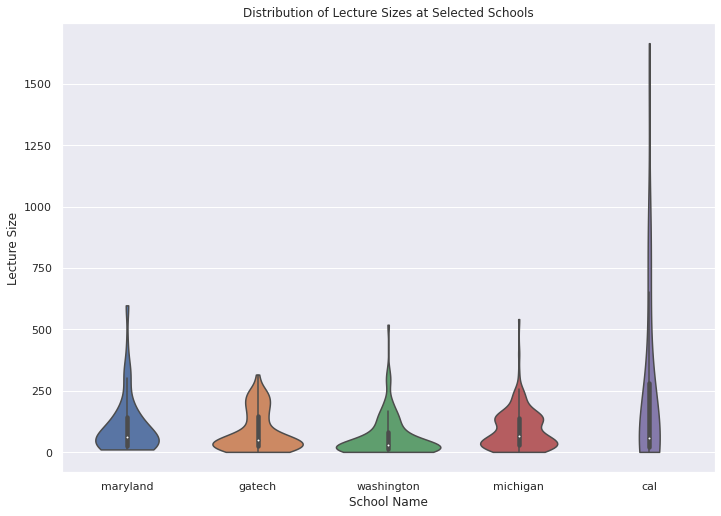

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# setting size of Seaborn plots
sns.set(rc={'figure.figsize':(11.7,8.27)})

# add school name abbreviation to each scraped class size dataframe
umd["school_name"] = "maryland"
gatech["school_name"] = "gatech"
uwash["school_name"] = "washington"
michigan["school_name"] = "michigan"
berkeley["school_name"] = "cal"

# create the dataset for the violin plot
umd_sizes = pd.DataFrame({"school_name": umd["school_name"].values, "class_size": umd["count"].values})
gatech_sizes = pd.DataFrame({"school_name": gatech["school_name"].values, "class_size": gatech["filled_seats"].values})
uwash_sizes = pd.DataFrame({"school_name": uwash["school_name"].values, "class_size": uwash["class_filled"].values})
michigan_sizes = pd.DataFrame({"school_name": michigan["school_name"].values, "class_size": michigan["course_enrollment"].values})
berkeley_sizes = pd.DataFrame({"school_name": berkeley["school_name"].values, "class_size": berkeley["course_enrollment"].values})

all_class_sizes = pd.concat([umd_sizes, gatech_sizes, uwash_sizes, michigan_sizes, berkeley_sizes], axis=0)

fig, axes = plt.subplots()

sns.violinplot(x="school_name", y="class_size", data=all_class_sizes, ax=axes, cut=0)
axes.set_title("Distribution of Lecture Sizes at Selected Schools")
axes.set_xlabel("School Name")
axes.set_ylabel("Lecture Size")

First, let's discuss the similarities. Almost all of the schools seem to have a bulk of their lectures under 250 students. Also, all the schools other than Georgia Tech have a couple mega-lectures, but Berkeley clearly takes the prize in this category with over 1500 students enrolled in their largest lecture.

Now, the differences. Maryland has mostly small lectures of under 200 students but has a relatively high proportion of lectures in the 250 to 500 student range compared to other schools. Georgia Tech doesn't offer mega-lectures but offers a relatively large proportion of lectures which are in the middle size range of 100-250 students compared to the other schools. Washington has most of it's lectures under 250 students with a large majority under 100 students, which is not similar to other schools. Michigan has two clear peaks of lecture sizes with the first around 50 students and teh second around 175 students. Cal offers a proportionally small amount of small lectures compared to the other schools.

### Lecture Sizes of 5 Schools Based on Scraped Data

Here we're going to plot the average lecture size for the scraped data at each of the 5 universities. The faculty in this case are only the professors teaching lectures. This might not be the most meaningful because we saw from the violin plot that there were possible outliers and heavy skew.

Text(0, 0.5, 'School')

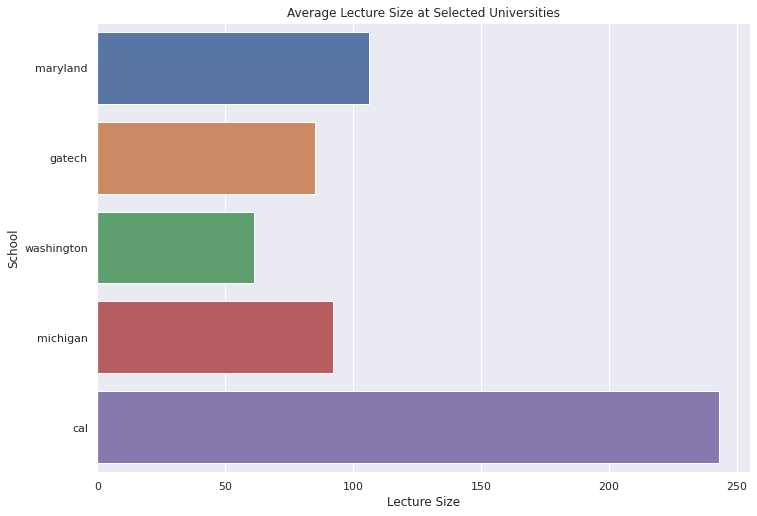

In [28]:
schools = ["maryland", "gatech", "washington", "michigan", "cal"]
ratios = [umd_sizes["class_size"].mean(), gatech_sizes["class_size"].mean(), uwash_sizes["class_size"].mean(), michigan_sizes["class_size"].mean(), berkeley_sizes["class_size"].mean()]

fig = sns.barplot(y=schools, x=ratios)
fig.set_title("Average Lecture Size at Selected Universities")
fig.set_xlabel("Lecture Size")
fig.set_ylabel("School")

So just going by averages, which I mentioned will be off for these schools due to the skew and outliers, Cal has the biggest average class size and Washington the smallest. Georgia Tech and Michigan both have their average class sizes under 100 with Georgia Tech slightly lower than Michigan. Maryland is a clear 4th place with an average class size of over 100.

Since averages are problematic, I'll plot the medians below:

Text(0, 0.5, 'School')

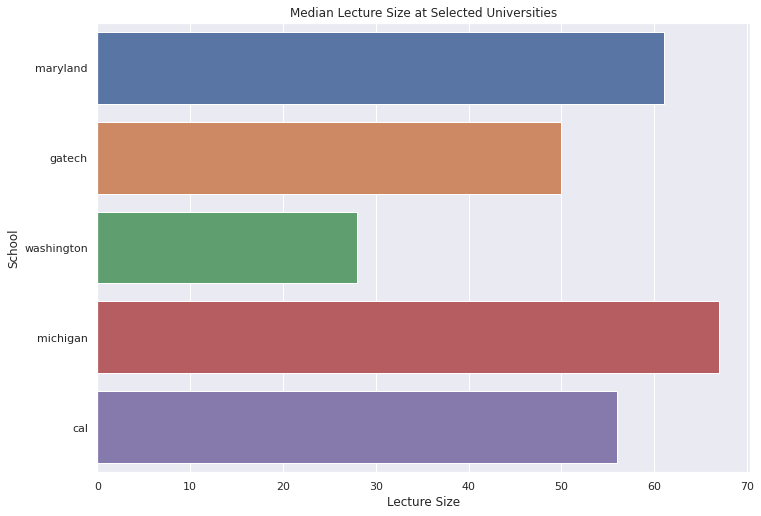

In [29]:
ratios = [umd_sizes["class_size"].median(), gatech_sizes["class_size"].median(), uwash_sizes["class_size"].median(), michigan_sizes["class_size"].median(), berkeley_sizes["class_size"].median()]

fig = sns.barplot(y=schools, x=ratios)
fig.set_title("Median Lecture Size at Selected Universities")
fig.set_xlabel("Lecture Size")
fig.set_ylabel("School")

Looking at medians shows a completely different picture. Cal's average lecture size looks to be brought up by a few mega-lectures. Another interesting thing to note is that all schools except Georgia Tech had their median lecture size be lower than their average lecture size. This suggests that for these schools, their averages are brought up by some relatively large lectures. Georgia Tech is interesting because their median is higher than their average. This suggests that they have few large lectures which would increase their average.

### Student to Faculty Ratio based on CSRankings Faculty Counts and Estimated Majors

I'll add a student:faculty ratio column to the aggregated dataframe cs_depts. Then I'll make a bar plot.

Text(0, 0.5, 'School')

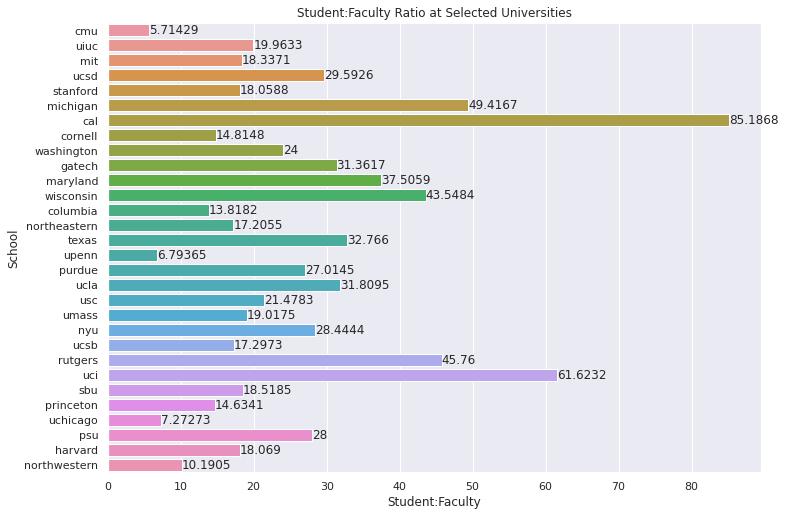

In [30]:
cs_depts["ratio"] = cs_depts["estimated_majors"] / cs_depts["faculty_count"]

fig = sns.barplot(y=cs_depts["abbrv"].values, x=cs_depts["ratio"].values)
fig.bar_label(fig.containers[0])
fig.set_title("Student:Faculty Ratio at Selected Universities")
fig.set_xlabel("Student:Faculty")
fig.set_ylabel("School")

Schools in this barplot are listed from highest ranking at the top to lowest ranking at the bottom according the CSRankings. Just from eyeballing the chart, it looks like private schools have much smaller student:faculty ratios than public schools. Cal is  still a big outlier among the 30 schools in regards to student:faculty ratio. At the top 5 schools, there seems to be relatively low student:faculty ratio. Maryland seems to be on the high side relative to the top-30 schools.

### Average Student:Faculty Ratio at Public and Private Universities

Text(0, 0.5, 'Student:Faculty Ratio')

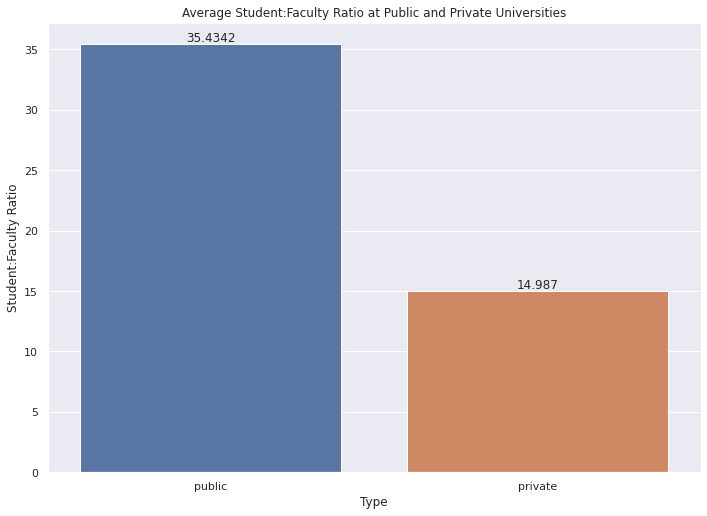

In [31]:
private = cs_depts[cs_depts["type"] == "private"]
public = cs_depts[cs_depts["type"] == "public"]

x = ["public", "private"]
y = [public["ratio"].mean(), private["ratio"].mean()]

fig = sns.barplot(x=x, y=y)
fig.bar_label(fig.containers[0])
fig.set_title("Average Student:Faculty Ratio at Public and Private Universities")
fig.set_xlabel("Type")
fig.set_ylabel("Student:Faculty Ratio")

It seems that my eyeballing of all 30 schools was correct and private universities do have smaller student:faculty ratios than public universities. Less than half as many private school students would be competing for each professor compared to their peers in public schools.

### Dollars of Estimated Tuition Income Per Faculty

In a hypothetical scenario where all CS students'tuition was divided equally by faculty of the CS department, the following chart shows how much each faculty member would receive in income. Schools with high income per faculty can be considered to have a higher "margin" on their product. They don't have to "sell"(aka. hire as many faculty) as other schools to bring in the same income in undergraduate tuition. This can possibly be seen as representative of the real world where some percentage of undergraduate tuition actually does go to the CS department.

Text(0, 0.5, 'School')

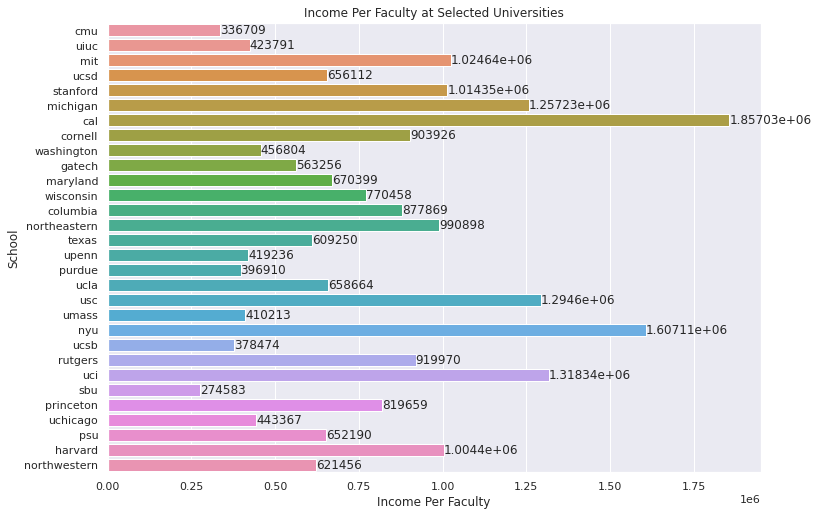

In [32]:
cs_depts["dol_per_fac"] = cs_depts["estimated_cost"] * cs_depts["estimated_majors"] / cs_depts["faculty_count"]

fig = sns.barplot(y=cs_depts["abbrv"].values, x=cs_depts["dol_per_fac"].values)
fig.bar_label(fig.containers[0])
fig.set_title("Income Per Faculty at Selected Universities")
fig.set_xlabel("Income Per Faculty")
fig.set_ylabel("School")

I would have thought that higher ranking institutions would generally bring in higher "margins" since people are drawn to prestige and well known professors. Some places like CMU have suprisingly low numbers because they have a low student:faculty ratio, which has more of a drag on income than their higher tuition costs. There also doesn't seem to be a strong pattern between a university being public or private and the income per professor. Maryland seems to be around middle of the pack in regards to income per faculty member.

### School Ranking vs. Student:Faculty Ratio

Hypothesis: CSRankings is based on research output not undergraduate teaching, so there should be a weak positive correlation between student:faculty ratios and ranking (positive in the sense better=ranking lower numerically). USNews is more of a subjective ranking but also based on research output. I think there will be a stronger positive correlation here because it's more subjective and up to "prestige". More prestigious universities should have less students in their department because they have less space, but they get their prestige through research, so will have a relatively high faculty number.

To test this hypothesis I will do a linear regression to see if ranking and student:faculty ratios are positively correlated. I believe linear is the correct model instead of something polynomial because student:faculty ratio should proportionally change relative to ranking. First I'll check my hypothesis using the CSRankings ranks.

Text(0, 0.5, 'Student:Faculty')

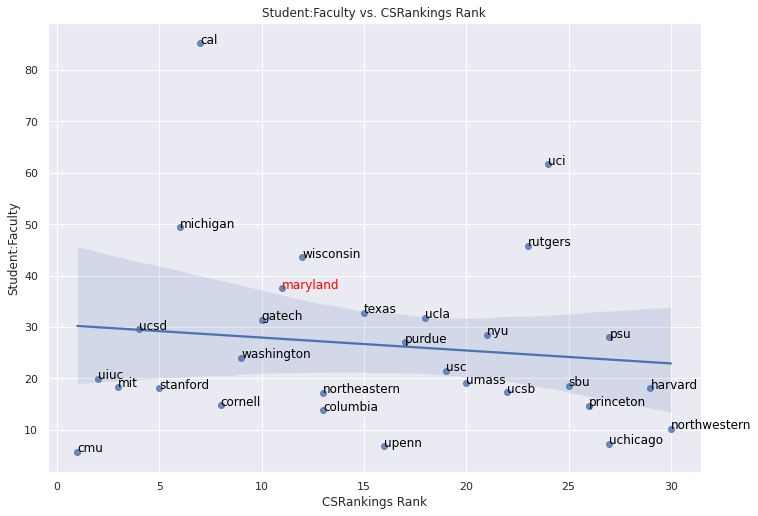

In [33]:
fig = sns.regplot(x=cs_depts["csr_rank"], y=cs_depts["ratio"])
# labeling
for i, txt in enumerate(cs_depts["abbrv"]):
    c = "black"
    if "maryland" in txt:
        c = "red"
    fig.annotate(txt, (cs_depts["csr_rank"][i], cs_depts["ratio"][i]), color=c)

fig.set_title("Student:Faculty vs. CSRankings Rank")
fig.set_xlabel("CSRankings Rank")
fig.set_ylabel("Student:Faculty")

In [52]:
import statsmodels.api as sm

y = cs_depts["ratio"].values
x = cs_depts["csr_rank"].values
x = sm.add_constant(x)

mod = sm.OLS(y, x)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.4676
Date:                Sat, 14 May 2022   Prob (F-statistic):              0.500
Time:                        21:12:21   Log-Likelihood:                -127.13
No. Observations:                  30   AIC:                             258.3
Df Residuals:                      28   BIC:                             261.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.4516      6.495      4.689      0.000      17.148      43.755
x1            -0.2513      0.367     -0.684      0.500      -1.004       0.501
==============================================================================
Omnibus:                       17.131   Durbin-Watson:                   1.667
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.235
Skew:                           1.524   Prob(JB):                     4.04e-05
Kurtosis:                       5.626   Cond. No.                         36.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So it turns out that my hypothesis was completely off. Instead of being a small positive correlation between CSRankings rank and student:faculty ratio it was actually a small negative correlation. This means that, counterintuitively, the higher ranking the department, the higher the student:faculty ratio. This can perhaps be explained by the observation that public universities are ranked highly for CS and it's already been shown that student:faculty ratios are higher for public universities than private ones. The high proportion of public universities in top of the rankings, along with schools like Cal and Michigan with high student:faculty ratios, and lower student:faculty ratios at private universities in the bottom of the top-30 help contribute to this negative correlation.

Although, the very small R^2 value suggests that very little of the variation in the student:faculty ratios can be explained by CSRankings Rank. Also, the F-Statistic probability is very high meaning that the model is not statistically significant. Overall, student:faculty ratios and CSRankings rank don't look to be related.

Next, I'll test the hypothesis using the USNews ranks.

Text(0, 0.5, 'Student:Faculty')

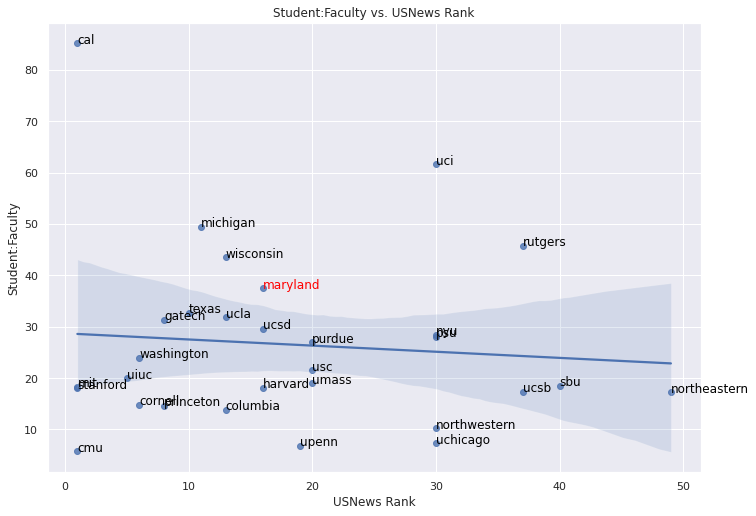

In [35]:
fig = sns.regplot(x=cs_depts["usn_rank"], y=cs_depts["ratio"])
# labeling
for i, txt in enumerate(cs_depts["abbrv"]):
    c = "black"
    if "maryland" in txt:
        c = "red"
    fig.annotate(txt, (cs_depts["usn_rank"][i], cs_depts["ratio"][i]), color=c)
    
fig.set_title("Student:Faculty vs. USNews Rank")
fig.set_xlabel("USNews Rank")
fig.set_ylabel("Student:Faculty")

In [36]:
y = cs_depts["ratio"].values
x = cs_depts["usn_rank"].values
x = sm.add_constant(x)

mod = sm.OLS(y, x)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.2311
Date:                Sat, 14 May 2022   Prob (F-statistic):              0.634
Time:                        20:39:38   Log-Likelihood:                -127.25
No. Observations:                  30   AIC:                             258.5
Df Residuals:                      28   BIC:                             261.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.7118      5.467      5.252      0.000      17.514      39.910
x1            -0.1194      0.248     -0.481      0.634      -0.628       0.389
==============================================================================
Omnibus:                       16.788   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.423
Skew:                           1.514   Prob(JB):                     6.06e-05
Kurtosis:                       5.524   Cond. No.                         37.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Like the CSRankings ranks, the result here goes against my hypothesis that student:faculty ratio and USNews ranking would be positively correlated. There is a very small negative correlation here between student:faculty ratio and USNews ranking. The small R^2 value, again, means that the variation of student:faculty ratio can't really be explained by USNews ranking. The small probability of the F-statistic also tells me that this model isn't statistically significant.

After looking at these two models for the two different rankings, school ranking seems to have almost no impact on student:faculty ratio despite the reasonable logic that higher ranking schools would have smaller student to faculty ratios.

### USNews Ranking vs. CSRankings Ranking

Hypothesis: USNews and CSRankings are generally ranking research output, so they should generally be trying to measure the same quantities. Thus, I think there should be a moderately-strong positive correlation between USNews ranking and CSRankings ranking.

I'll plot the data and then do statistical analysis to test my hypothesis. The blue line on the plot will be the linear regression line. The red line on the plot will be if both rankings are perfectly correlated. If a school is under the red line, they perform better on the CSRankings Rank than USNews and vice-versa.

Text(0, 0.5, 'CSRankings Rank')

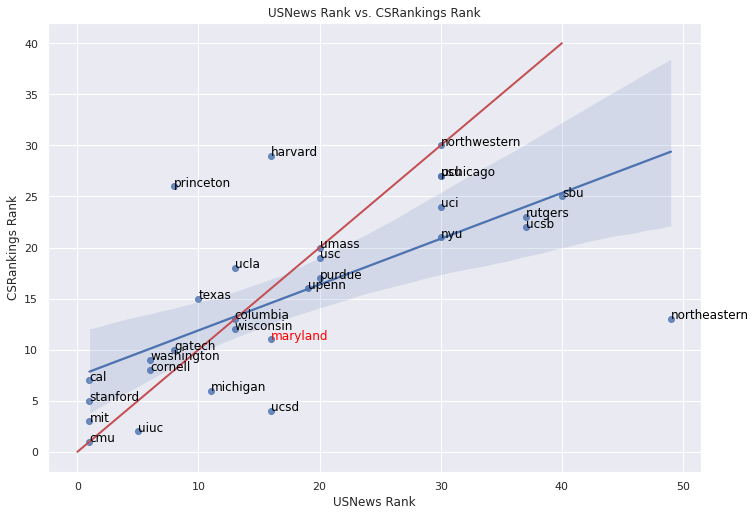

In [42]:
fig = sns.regplot(x=cs_depts["usn_rank"], y=cs_depts["csr_rank"])

# labeling
for i, txt in enumerate(cs_depts["abbrv"]):
    c = "black"
    if "maryland" in txt:
        c = "red"
    fig.annotate(txt, (cs_depts["usn_rank"][i], cs_depts["csr_rank"][i]), color=c)
    
# plot slope of 1 line with intercept at 0, shows which schools perform better on which ranking system
fig.plot([0,40], [0,40], linewidth = 2, color="r")
    
fig.set_title("USNews Rank vs. CSRankings Rank")
fig.set_xlabel("USNews Rank")
fig.set_ylabel("CSRankings Rank")

From just looking at the regression line plotted, it seems that my hypothesis that there would be a positive correlation between the rankings was correct. I'll do the statistical calculations below to prove it.

Also, I drew a red line in the imaginary situation when both rankings were perfectly positively correlated. Most schools don't fall on this line with some performing better on USNews or CSRankings. Maryland seems to perform well on the CSRankings rank compared to USNews. Northeastern's rankings are very different and I wonder what causes USNews to rank them so low when they produce top-15 research output numbers according to CSRankings.

In [38]:
y = cs_depts["csr_rank"].values
x = cs_depts["usn_rank"].values
x = sm.add_constant(x)

mod = sm.OLS(y, x)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     22.33
Date:                Sat, 14 May 2022   Prob (F-statistic):           5.88e-05
Time:                        20:39:39   Log-Likelihood:                -98.384
No. Observations:                  30   AIC:                             200.8
Df Residuals:                      28   BIC:                             203.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4054      2.088      3.546      0.001       3.127      11.683
x1             0.4485      0.095      4.725      0.000       0.254       0.643
==============================================================================
Omnibus:                        2.173   Durbin-Watson:                   1.041
Prob(Omnibus):                  0.337   Jarque-Bera (JB):                0.996
Skew:                           0.129   Prob(JB):                        0.608
Kurtosis:                       3.854   Cond. No.                         37.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The statistical calculations suggest that the linear regression model calculated above is statistically significant because the probability of the F-statistic value is very small. Also, the R^2 implies that R is around 0.666, which could be defined as a moderately strong positive correlation. Thus, my hypothesis was correct.

Some reasons why there isn't perfect positive correlation(R=1) are that CSRankings just focuses on research output with no subjective component. A lot of what goes into USNews' rankings is peer evaluation, which is probably only a moderate signal for research output with other biases baked in.

### School Ranking vs. Alumni in Big Tech

Hypothesis: Higher ranking schools should have a larger standardized amount of their alumni in Big Tech. This is because higher ranking should be a proxy for better students, and Big Tech is presumably looking for the best students to hire. This means that there should be a moderately strong negative correlation since higher ranking is lower numerically. 

I will be standardizing on size of CS department. This means the Alumni number is the alumni in Big Tech per CS major in that department.

Limitation: Alumni data may include non software engineering alumni.

Text(0, 0.5, 'Standardized Alumni')

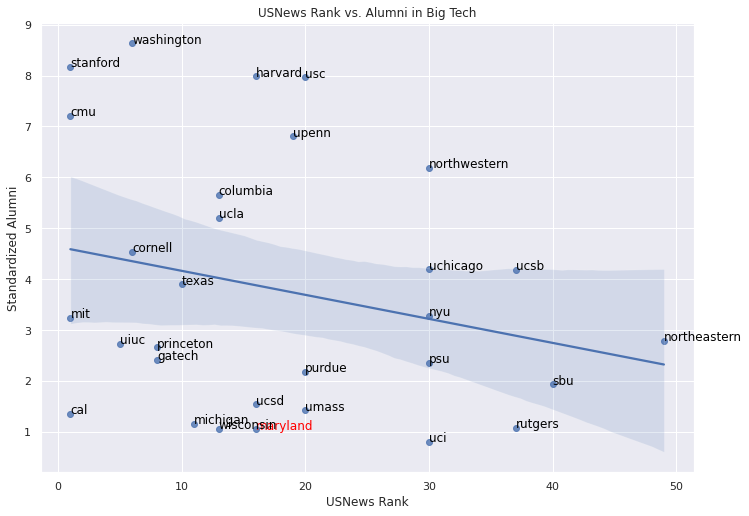

In [47]:
alumni = alumni.groupby("school", sort=False)
alumni = alumni.agg({"count": "sum"})

# add alumni count to cs_depts dataframe
cs_depts["alumni"] = alumni["count"].values

# standardize alumni count based on esimated majors
cs_depts["alumni"] = cs_depts["alumni"] / cs_depts["estimated_majors"]

fig = sns.regplot(x=cs_depts["usn_rank"], y=cs_depts["alumni"])

# labeling
for i, txt in enumerate(cs_depts["abbrv"]):
    c = "black"
    if "maryland" in txt:
        c = "red"
    fig.annotate(txt, (cs_depts["usn_rank"][i], cs_depts["alumni"][i]), color=c)
    
fig.set_title("USNews Rank vs. Alumni in Big Tech")
fig.set_xlabel("USNews Rank")
fig.set_ylabel("Standardized Alumni")

The plot confirms my hypothesis that there is a negative correlation between school rank and alumni in Big Tech. However, this correlation may not be as strong as I presumed.

Washington has the highest alumni rate which is interesting. It beats out Stanford, Harvard, CMU, MIT, and Princeton. Like I said in my limitations, the data includes people who are not just software engineers with CS degrees. A reasonable guess is that Amazon and Microsoft love to hire people out of Washinton into all roles in the company, not just software engineering.

There is also a pretty clear public/private university divide, with private universities having much higher alumni numbers than public ones. A reason for this may be because some of these private universities have well-known schools to get an MBA. Another reason could be the stronger alumni network in these private universities. Maryland performs similarly to other public universities. Penn State does suprisingly well, beating out much higher ranked public universities. Another note is that the public universities which have high alumni numbers also seem to be located on the west coast. It makes sense that Big Tech would like to recruit in their backyard.

In [48]:
y = cs_depts["alumni"].values
x = cs_depts["usn_rank"].values
x = sm.add_constant(x)

mod = sm.OLS(y, x)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.820
Date:                Sat, 14 May 2022   Prob (F-statistic):              0.188
Time:                        21:02:56   Log-Likelihood:                -68.432
No. Observations:                  30   AIC:                             140.9
Df Residuals:                      28   BIC:                             143.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6357      0.770      6.024      0.000       3.059       6.212
x1            -0.0472      0.035     -1.349      0.188      -0.119       0.024
==============================================================================
Omnibus:                        4.799   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                2.486
Skew:                           0.450   Prob(JB):                        0.288
Kurtosis:                       1.913   Cond. No.                         37.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The statistical calculations confirm the negative correlation with R being around -0.25, but this is a weak negative correlation. The p-value for the F-statistic is also high enough that I wouldn't consider this linear model to be statistically significant.

I'll now do the same plotting and calculations for the CSRankings rank to see if there are different results.

Text(0, 0.5, 'Standardized Alumni')

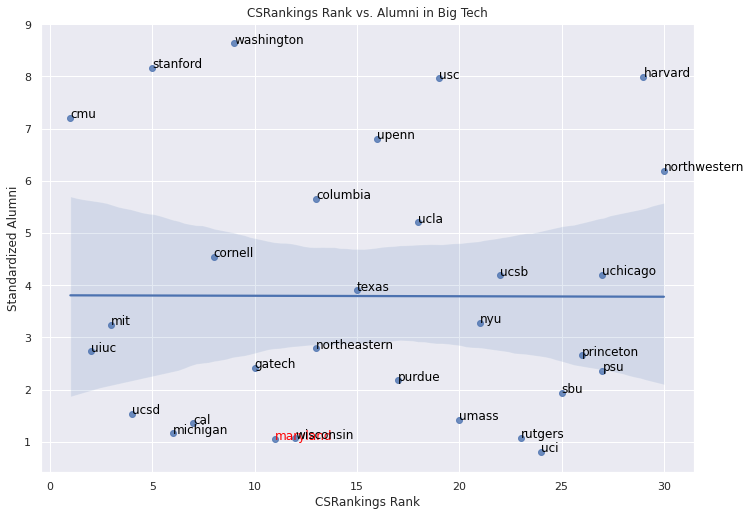

In [49]:
fig = sns.regplot(x=cs_depts["csr_rank"], y=cs_depts["alumni"])

# labeling
for i, txt in enumerate(cs_depts["abbrv"]):
    c = "black"
    if "maryland" in txt:
        c = "red"
    fig.annotate(txt, (cs_depts["csr_rank"][i], cs_depts["alumni"][i]), color=c)
    
fig.set_title("CSRankings Rank vs. Alumni in Big Tech")
fig.set_xlabel("CSRankings Rank")
fig.set_ylabel("Standardized Alumni")

Wow, so if looking at raw research output rankings, there seems to be absolutely no correlation to how many alumni are in Big Tech.

It's interesting that USNews has a significantly stronger correlation than CSRankings because both are presumably measuring strength of graduate schools which doesn't necessarily depend on Big Tech employment. Though, the stronger the graduate school, the more likely it has good connections with Big Tech.

In [51]:
y = cs_depts["alumni"].values
x = cs_depts["csr_rank"].values
x = sm.add_constant(x)

mod = sm.OLS(y, x)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                 0.0003033
Date:                Sat, 14 May 2022   Prob (F-statistic):              0.986
Time:                        21:08:19   Log-Likelihood:                -69.376
No. Observations:                  30   AIC:                             142.8
Df Residuals:                      28   BIC:                             145.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8057      0.947      4.017      0.000       1.865       5.746
x1            -0.0009      0.054     -0.017      0.986      -0.111       0.109
==============================================================================
Omnibus:                        4.213   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                2.986
Skew:                           0.616   Prob(JB):                        0.225
Kurtosis:                       2.067   Cond. No.                         36.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The statistical calculations confirm that there is almost 0 correlation between CSRankings Rank and alumni in Big Tech. The linear regression model is also not statistically significant for these two variables.

## Conclusion

### Limitations

### Insights

### Further Research